In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 0. 데이터 준비

**데이터 로딩 밎 확인**

In [2]:
churn = pd.read_csv('data/churn_ver02.csv')
churn.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
CreditScore        10000 non-null int64
Gender             10000 non-null int64
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [4]:
churn.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

**랜덤 시드 고정**

In [5]:
np.random.seed(123)

**Train/Test 분할**

In [6]:
target = churn.Exited
churn = churn.drop('Exited', axis='columns')

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(churn, target, test_size=0.3, stratify=target)

## 1. 보팅(Voting)

**필요모듈 로딩 / 모형 정의**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

**파라미터 범위 정의**

In [10]:
lr_param = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'],
            'C' : np.concatenate([np.arange(1,101)/100, np.arange(1,11)*10])}

In [11]:
knn_param = {'n_neighbors':np.arange(1,201),
             'weights' : ['uniform','distance'],
             'p' : np.arange(10, 21)/10}

In [12]:
dt_param = {'criterion':['gini','entropy'],
            'max_depth': np.arange(1,31)}

**RandomSearchCV**

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
lr_best = RandomizedSearchCV(estimator=lr, param_distributions=lr_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
knn_best = RandomizedSearchCV(estimator=knn, param_distributions=knn_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
dt_best = RandomizedSearchCV(estimator=dt, param_distributions=dt_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)

In [15]:
lr_best.fit(x_train, y_train)
knn_best.fit(x_train, y_train)
dt_best.fit(x_train, y_train)

c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

**Best Prameter 확인 및 모형 저장**

In [16]:
print(lr_best.best_params_)
print(knn_best.best_params_)
print(dt_best.best_params_)

{'solver': 'newton-cg', 'C': 0.53}
{'weights': 'uniform', 'p': 1.7, 'n_neighbors': 155}
{'max_depth': 5, 'criterion': 'entropy'}


In [17]:
lr_best = lr_best.best_estimator_
knn_best = knn_best.best_estimator_
dt_best = dt_best.best_estimator_

In [18]:
pd.Series(lr_best.coef_[0], index=x_train.columns)

CreditScore       -0.003435
Gender            -0.580529
Age                0.062918
Tenure            -0.038392
Balance            0.000004
NumOfProducts     -0.318711
HasCrCard         -0.101836
IsActiveMember    -0.965318
EstimatedSalary   -0.000001
dtype: float64

In [19]:
pd.Series(dt_best.feature_importances_, index=x_train.columns)

CreditScore        0.005072
Gender             0.011218
Age                0.481020
Tenure             0.001753
Balance            0.056509
NumOfProducts      0.327648
HasCrCard          0.000000
IsActiveMember     0.105328
EstimatedSalary    0.011451
dtype: float64

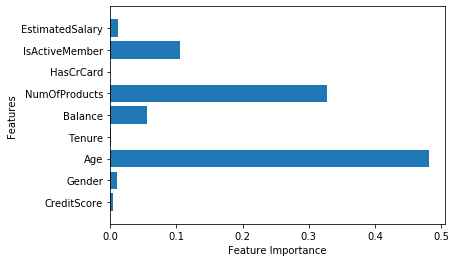

In [20]:
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x_train.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importances(dt_best)

**Voting**

In [21]:
from sklearn.ensemble import VotingClassifier

In [22]:
hard_vot = VotingClassifier(estimators=[('LR', lr_best), ('KNN', knn_best), ('DT', dt_best)], voting='hard')
soft_vot = VotingClassifier(estimators=[('LR', lr_best), ('KNN', knn_best), ('DT', dt_best)], voting='soft')

In [23]:
hard_vot.fit(x_train, y_train)
soft_vot.fit(x_train, y_train)

c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\program files\python37\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The 

VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=0.53, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='newton-cg', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('KNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkows...
                              DecisionTreeCl

In [24]:
from sklearn.metrics import roc_auc_score
models = [lr_best, knn_best, dt_best, hard_vot, soft_vot]
for model in models:
    pred = model.predict(x_test)
    name = model.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(name, roc_auc_score(y_test, pred)))

LogisticRegression 정확도: 0.5638
KNeighborsClassifier 정확도: 0.5000
DecisionTreeClassifier 정확도: 0.6859
VotingClassifier 정확도: 0.5643
VotingClassifier 정확도: 0.5795


## 2. 랜덤 포레스트(Random Forest)

**최적파라미터 탐색**

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [26]:
rf_param = {'n_estimators':np.arange(2,101),
            'max_depth':np.arange(1,31),
            'criterion':['gini','entropy']}

In [27]:
rf_best = RandomizedSearchCV(estimator=rf, param_distributions=rf_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
rf_best.fit(x_train, y_train)
print(rf_best.best_params_)
rf_best = rf_best.best_estimator_

{'n_estimators': 95, 'max_depth': 8, 'criterion': 'entropy'}


**성능 확인**

In [28]:
models = [lr_best, knn_best, dt_best, hard_vot, soft_vot, rf_best]
for model in models:
    pred = model.predict(x_test)
    name = model.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(name, roc_auc_score(y_test, pred)))

LogisticRegression 정확도: 0.5638
KNeighborsClassifier 정확도: 0.5000
DecisionTreeClassifier 정확도: 0.6859
VotingClassifier 정확도: 0.5643
VotingClassifier 정확도: 0.5795
RandomForestClassifier 정확도: 0.6942


**변수 중요도 추출**

In [29]:
f_imp = rf_best.feature_importances_
f_imp = pd.Series(f_imp, index=x_train.columns)
f_imp = f_imp.sort_values(ascending=False)
f_imp

Age                0.373421
NumOfProducts      0.269897
Balance            0.097489
IsActiveMember     0.069830
CreditScore        0.065959
EstimatedSalary    0.061004
Tenure             0.033319
Gender             0.021801
HasCrCard          0.007280
dtype: float64

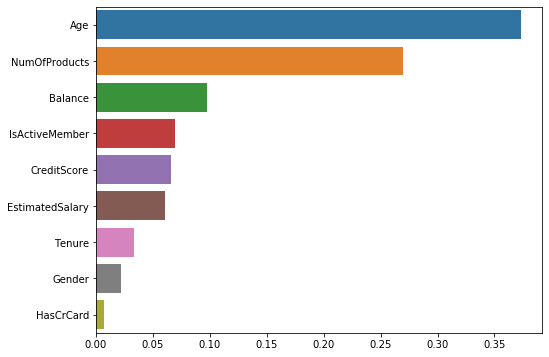

In [30]:
plt.figure(figsize=(8,6))
sns.barplot(x=f_imp, y=f_imp.index);

## 3. AdaBoost

**최적파라미터 탐색**

In [31]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=dt_best)

In [32]:
ada_param = {'n_estimators' : np.arange(2, 101),
             'learning_rate' : np.arange(1,101)/100,
             'algorithm': ['SAMME','SAMME.R']}

In [33]:
ada_best = RandomizedSearchCV(estimator=ada, param_distributions=ada_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
ada_best.fit(x_train, y_train)
print(ada_best.best_params_)
ada_best = ada_best.best_estimator_

{'n_estimators': 78, 'learning_rate': 0.24, 'algorithm': 'SAMME'}


**성능 확인**

In [34]:
models = [lr_best, knn_best, dt_best, hard_vot, soft_vot, rf_best, ada_best]
for model in models:
    pred = model.predict(x_test)
    name = model.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(name, roc_auc_score(y_test, pred)))

LogisticRegression 정확도: 0.5638
KNeighborsClassifier 정확도: 0.5000
DecisionTreeClassifier 정확도: 0.6859
VotingClassifier 정확도: 0.5643
VotingClassifier 정확도: 0.5795
RandomForestClassifier 정확도: 0.6942
AdaBoostClassifier 정확도: 0.7054


## 4. GBM

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [36]:
gb_param = {'loss':['deviance', 'exponential'],
            'n_estimators' : np.arange(2, 201),
            'learning_rate' : np.arange(1,101)/100,
            'max_depth':np.arange(1,31),
            'criterion':['firedman_mse','mae','mse']}

In [37]:
gb.fit(x_train, y_train)
#gb_best = RandomizedSearchCV(estimator=gb, param_distributions=gb_param, n_iter=15, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
#gb_best.fit(x_train, y_train)
#print(gb_best.best_params_)
#gb_best = gb_best.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**성능 확인**

In [38]:
models = [lr_best, knn_best, dt_best, hard_vot, soft_vot, rf_best, ada_best, gb]
for model in models:
    pred = model.predict(x_test)
    name = model.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(name, roc_auc_score(y_test, pred)))

LogisticRegression 정확도: 0.5638
KNeighborsClassifier 정확도: 0.5000
DecisionTreeClassifier 정확도: 0.6859
VotingClassifier 정확도: 0.5643
VotingClassifier 정확도: 0.5795
RandomForestClassifier 정확도: 0.6942
AdaBoostClassifier 정확도: 0.7054
GradientBoostingClassifier 정확도: 0.7193


In [39]:
models = [lr_best, knn_best, dt_best, hard_vot, soft_vot, rf_best, ada_best, gb]
score = []
names = []
for model in models:
    pred = model.predict(x_test)
    name = model.__class__.__name__
    score.append(roc_auc_score(y_test, pred))
    names.append(name)
results = pd.Series(score, index=names)
results

LogisticRegression            0.563815
KNeighborsClassifier          0.500000
DecisionTreeClassifier        0.685916
VotingClassifier              0.564345
VotingClassifier              0.579474
RandomForestClassifier        0.694233
AdaBoostClassifier            0.705443
GradientBoostingClassifier    0.719336
dtype: float64

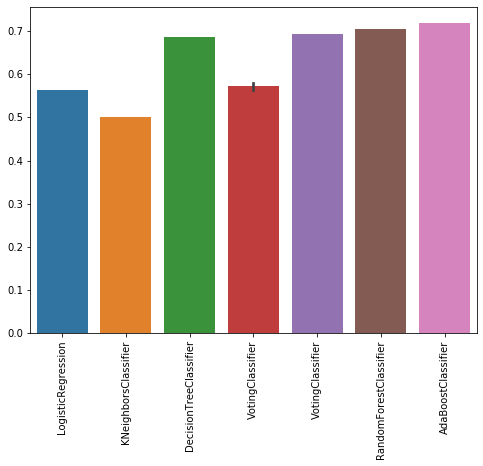

In [40]:
plt.figure(figsize=(8,6))
g = sns.barplot(x=results.index, y=results)
g.set_xticklabels(labels=results.index, rotation=90);